In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --force-reinstall matplotlib

In [ ]:
import sys
!{sys.executable} -m pip uninstall -y matplotlib
!{sys.executable} -m pip install --no-cache-dir matplotlib

In [2]:
import matplotlib
print(matplotlib.__version__)
print(hasattr(matplotlib, "rcParams"))  # deve retornar True

3.10.5
True


In [ ]:
import sys
!{sys.executable} -m pip uninstall -y numpy
!{sys.executable} -m pip install --no-cache-dir --force-reinstall numpy

In [2]:
import numpy as np
print(np.__version__)
print(np.array([1,2,3]))

2.3.2
[1 2 3]


In [ ]:
!{sys.executable} -m pip install numpy==1.26.4

In [2]:
from ultralytics import YOLO
import torch
import cv2
import matplotlib.pyplot as plt
import os

In [4]:
# Se estiver usando GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Video loaded successfully!
Resolution: 640x360, FPS: 14.985014985014985
Output path: results/fall_detect_yolo11n_pose_balanced/yolo_video_test/059Y.mp4


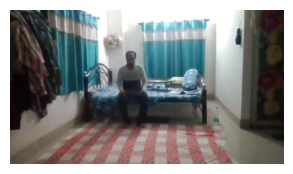

In [6]:
### Script YOLOv11 Video Test
# Path to the video
OUTPUT_BASE_PATH = "results/fall_detect_yolo11n_pose_balanced"
VIDEO_PATH = "videos_test/" # _le2i
PREDICT_PATH = f"{OUTPUT_BASE_PATH}/yolo_video_test"
FILENAME_IN = "059"
FILENAME_OUT = "059Y"

cap = cv2.VideoCapture(f"{VIDEO_PATH}/{FILENAME_IN}.mp4")

if not cap.isOpened():
    print("Error opening the video!")
else:
    print("Video loaded successfully!")

# Video information
ret, frame = cap.read()
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

print(f"Resolution: {frame_width}x{frame_height}, FPS: {fps}")

# Video output check
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_path = f"{PREDICT_PATH}/{FILENAME_OUT}.mp4"
os.makedirs(PREDICT_PATH, exist_ok=True) 
out = cv2.VideoWriter(output_path, fourcc, 20.0, (frame_width, frame_height))

if not out.isOpened():
    print("[ERROR] VideoWriter initialization error.")
else:
    print(f"Output path: {output_path}")

if ret:
    plt.figure(figsize=(4,2))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [8]:
# MODEL PREDICT (BOUNDING BOX)
# Frame processing
BASE_PATH = "results/fall_detect_yolo11n_pose_balanced"
MODEL_PATH = f"{BASE_PATH}/yolo11n_pose_train/weights/best.pt"
RUN_NAME = "yolo11n_pose_predict"
loading = "Processing..."
frames_processed = 0

# Loading of trained model
try:
    yolo_model = YOLO(MODEL_PATH)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

print(f'\r{loading}', end='', flush=True)

def round_to_multiple_of_32(x):
    return int((x + 31) // 32 * 32)   # arredonda para cima

imgsz_w = round_to_multiple_of_32(frame_width)
imgsz_h = round_to_multiple_of_32(frame_height)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Model predict YOLO   
    results = yolo_model.predict(
        source=frame, 
        imgsz=(imgsz_w, imgsz_h), 
        conf=0.5, 
        save=False, # frame a frame saving
        verbose=False,
        project=BASE_PATH,
        name=RUN_NAME
    )

    class_info = {
        0: {"name": "no_fall", "color": (255, 0, 0)},     # Azul
        1: {"name": "fall", "color": (0, 0, 255)},        # Vermelho
        2: {"name": "attention", "color": (0, 255, 255)}  # Amarelo
    }

    # Copy frame to draw manually
    annotated_frame = frame.copy()
    
    # Detection check
    if results[0].keypoints is not None and results[0].boxes is not None:
        #if len(results[0].boxes.data) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy().astype(int)
        confs = results[0].boxes.conf.cpu().numpy()
    
        for i, (box, cls_id, conf) in enumerate(zip(boxes, classes, confs)):
            cls_data = class_info.get(cls_id)
            color = cls_data["color"]
            cls_name = cls_data["name"]
            
            # Draw bounding box
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)

            # Class and confidence
            label = f"{cls_name} ({conf:.2f})"
            cv2.putText(annotated_frame, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    annotated_frame_resized = cv2.resize(annotated_frame, (frame_width, frame_height))

    # Write the annotated frame in the output file
    out.write(annotated_frame_resized)
    frames_processed += 1

# Release the object of video capture and write
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"{frames_processed} processed frames and saved in {output_path}")

Model loaded successfully!
Processing...177 processed frames and saved in results/fall_detect_yolo11n_pose_balanced/yolo_video_test/059Y.mp4
